# Credit-Risk-Analysis

A project for the Neural Networks discipline mentored by Prof. Dr.  Germano Vasconcelos  (http://www.cin.ufpe.br/~gcv/web_lci/germano.html) at Centro de Informática, UFPE, Brazil (cin.ufpe.br).

Using mlp to classifier samples as either good or bad in credit risk analysis context.

In [1]:
import numpy as np
import pandas as pd 
import keras
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve

from collections import Counter
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt

/home/msb5/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Reading datasets

In [2]:
train = pd.read_csv('train1.csv', index_col=0)
val = pd.read_csv('val1.csv', index_col ='INDEX')
test = pd.read_csv('test.csv',index_col = 'INDEX')

### Splitting data into train, test and validation

In [3]:
cols_train = [col for col in train.columns if col != 'y']
cols_test = [col for col in test.columns if col != 'y']
X_train = train[cols_train]
y_train = train['y']
X_test = test[cols_test]
y_test = test['y']
X_val = val[cols_test]
y_val = val['y']

### Setting and training a MLP

In [5]:
input_dim = X_train.shape[1]

categorical_labels = to_categorical(y_train, num_classes=2)

mlp = Sequential()

mlp.add(Dense(40,activation='relu',input_dim = input_dim))
mlp.add(Dense(40,activation='relu'))
mlp.add(Dense(40,activation='relu'))
mlp.add(Dense(40,activation='relu'))
mlp.add(Dense(40,activation='relu'))
mlp.add(Dense(40,activation='relu'))
mlp.add(Dense(40,activation='relu'))
mlp.add(Dense(40,activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))
mlp.compile(optimizer='adam',loss='mean_squared_logarithmic_error')

history = mlp.fit(X_train, y_train, batch_size=64, epochs= 10000,callbacks=[EarlyStopping(patience=500)], verbose=0, validation_data=[X_val,y_val])

### Methods definitions
1. Generate distances
2. Compute performance metrics: accuracy, recall, precision and f1
3. Extract final losses from train step
4. Print a summary of metrics

In [6]:
def generate_dist(probas, y):
    dist_1 = [0] * 100
    dist_2 = [0] * 100
    for_perc = Counter(y)
    for i in range(1,101):
        limiar = i/100
        lower = y[np.where(probas <= limiar)]
        count = Counter(lower)
        dist_1[i-1] = count[0]
        dist_2[i-1] = count[1]
    return np.array(dist_1)/for_perc[0], np.array(dist_2)/for_perc[1]


def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        gd = generate_dist(y_pred_scores,y.values)
        ks = ks_2samp(gd[0],gd[1])[0]
        performance_metrics = performance_metrics + (auroc, aupr, ks)
    return performance_metrics

def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None, ks=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))
    if ks is not None:
        print("{metric:<18}{value:.4f}".format(metric="KS:", value=ks))

### Predicting values with trained MLP
Displaying confusion matrix, train and validation losses, and performance summary

In [7]:
y_pred_scores = mlp.predict(X_test)
y_pred_class = mlp.predict_classes(X_test)

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')
print(confusion_matrix(y_test, y_pred_class))

## Resumo dos resultados
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))

print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr, ks = compute_performance_metrics(y_test, y_pred_class, np.concatenate(y_pred_scores))
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr, ks)

Matriz de confusão no conjunto de teste:
[[20719 12806]
 [25904 37870]]

Train Loss:       0.1024
Validation Loss:  0.1020

Performance no conjunto de teste:

Accuracy:         0.6022
Recall:           0.5938
Precision:        0.7473
F1:               0.6618
AUROC:            0.6278
AUPR:             0.7449
KS:               0.4400


### Graphic results

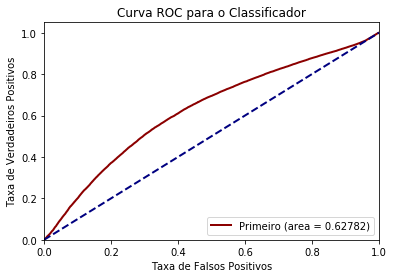

In [8]:
lw=2
roc_area = roc_auc_score(y_test, y_pred_scores)
fpr, tpr, _ = roc_curve(y_test, y_pred_scores)

plt.plot(fpr, tpr, color='darkred', lw=lw, label='Primeiro (area = %0.5f)' % roc_area)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC para o Classificador')
plt.legend(loc="lower right")
plt.show()